<a href="https://colab.research.google.com/github/revirevy/notebooks/blob/master/IFAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IFAN**

This notebook contains the demo program of the following paper:

<!-- ![image](https://github.com/codeslake/IFAN/blob/main/assets/IFAN_network.jpg) -->

>[Iterative Filter Adaptive Network for Single Image Defocus Deblurring](https://github.com/codeslake/IFAN)<br/>
>*Junyong Lee, Hyeongseok Son, Jaesung Rim, Sunghyun Cho and Seungyong Lee*<br/>
>In Proc. CVPR 2021


---
## 1. Prerequisites
  * Clone the repository and download checkpoints.

In [1]:
%cd /content/
!git clone https://acc5fb489fbbd969cb1f9f881630ae3554342ccf@github.com/codeslake/IFAN.git
%cd /content/IFAN
!mkdir ckpt

!wget https://www.dropbox.com/s/qohhmr9p81u0syi/checkpoints.zip
!unzip checkpoints.zip -d ckpt
!rm checkpoints.zip


/content
fatal: destination path 'IFAN' already exists and is not an empty directory.
/content/IFAN
mkdir: cannot create directory ‘ckpt’: File exists
--2024-08-08 12:09:41--  https://www.dropbox.com/s/qohhmr9p81u0syi/checkpoints.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/nm6vu5zi6rxz499f20txx/checkpoints.zip?rlkey=xkpn2iqh460963gkt90wob04g [following]
--2024-08-08 12:09:41--  https://www.dropbox.com/scl/fi/nm6vu5zi6rxz499f20txx/checkpoints.zip?rlkey=xkpn2iqh460963gkt90wob04g
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb28a04732d258acb2695b27e81.dl.dropboxusercontent.com/cd/0/inline/CYNeSojmT0dlbWqgCyLjj2TWNYNTdgQDiaiOuQeRmD5Ieies3qt9FwJ_C8y6PpUuZCJBLJgw2f30HblsGm6QbbV8UMcX7DUHzlTghPOJ6V9QUvci

In [2]:
!cat requirements.txt

easydict==1.9
opencv-python==4.5.5.64
ptflops==0.6.4
scikit-image==0.19.1
scikit-learn==1.4.2
scipy==1.7.3
sklearn==0.0
tensorboardX==2.1
termcolor==1.1.0
torch-optimizer==0.1.0
tqdm==4.56.0
protobuf>=3.20.2
jupyterlab


In [3]:
pwd

'/content/IFAN'

In [4]:
%%writefile requirements.txt
easydict==1.9
opencv-python==4.5.5.64
ptflops==0.6.4
scikit-image==0.19.1
scikit-learn==1.4.2
scipy==1.7.3
sklearn==0.0
tensorboardX==2.1
termcolor==1.1.0
torch-optimizer==0.1.0
tqdm==4.56.0
protobuf>=3.20.2
jupyterlab

Overwriting requirements.txt


In [5]:
!pip install pip -U
!pip install -r requirements.txt

* Initialize network

In [6]:
%cd /content/IFAN

import torch

import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import datetime

from configs.config_IFAN import get_config
from ckpt_manager import CKPT_Manager
from models import create_model

from utils import *

input_offset = 'demo/'

config = get_config('IFAN_CVPR2021', 'IFAN', 'config_IFAN')
config.network = 'IFAN'
model = create_model(config)
network = model.get_network().to().eval()

ckpt_manager = CKPT_Manager(root_dir='', model_name='IFAN', cuda=config.cuda)
load_state, ckpt_name = ckpt_manager.load_ckpt(network, abs_name = './ckpt/IFAN.pytorch')
print('\nLoading checkpoint \'{}\' on model \'{}\': {}\n'.format(ckpt_name, config.mode, load_state))

/content/IFAN
Loading Model...
	initializing deblurring network
Warning! No positional inputs found for a module, assuming batch size is 1.
Computing model complexity...
	Computational complexity (Macs):   419.517864 B
	Number of parameters:           10.476996 M

Loading checkpoint 'IFAN.pytorch' on model 'IFAN': _IncompatibleKeys(missing_keys=[], unexpected_keys=['module.reblurNet.RBF.0.0.weight', 'module.reblurNet.RBF.0.0.bias', 'module.reblurNet.RBF.1.stem.0.0.weight', 'module.reblurNet.RBF.1.stem.0.0.bias', 'module.reblurNet.RBF.1.stem.0.2.weight', 'module.reblurNet.RBF.1.stem.0.2.bias', 'module.reblurNet.RBF.1.stem.1.0.weight', 'module.reblurNet.RBF.1.stem.1.0.bias', 'module.reblurNet.RBF.1.stem.1.2.weight', 'module.reblurNet.RBF.1.stem.1.2.bias', 'module.reblurNet.RBF.2.stem.0.0.weight', 'module.reblurNet.RBF.2.stem.0.0.bias', 'module.reblurNet.RBF.2.stem.0.2.weight', 'module.reblurNet.RBF.2.stem.0.2.bias', 'module.reblurNet.RBF.2.stem.1.0.weight', 'module.reblurNet.RBF.2.stem.1

---
## 2.  Run IFAN
* *There is already a sample image for the demo. You can skip this cell.*
* But, if you want to test IFAN on different images, upload them by running this cell.
    >**Note:**
    >
    > This cell will clear previously imported input images

In [7]:
from google.colab import files
import os
import shutil

input_user_path = os.path.join(input_offset, 'input_user')

if os.path.isdir(input_user_path):
    shutil.rmtree(input_user_path)
os.mkdir(input_user_path)

uploaded = files.upload()
for key in uploaded.keys():
    abspath = os.path.abspath(key)
    os.rename(abspath, os.path.join(input_user_path, key))

Saving crim0148.jpg to crim0148.jpg


In [10]:
key,input_user_path

('crim0148.jpg', 'demo/input_user')

In [8]:
pwd

'/content/IFAN'


* Run IFAN

In [12]:
config.refine_val

8

Reading Input(s)...

====== DEMO START ======

[EVAL IFAN][01/02] input.jpg
Input


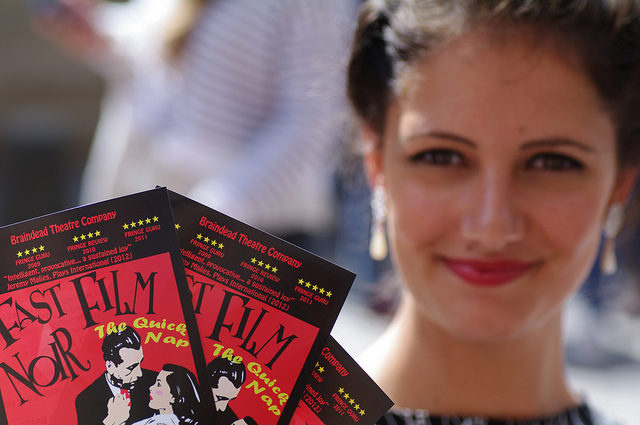


Output


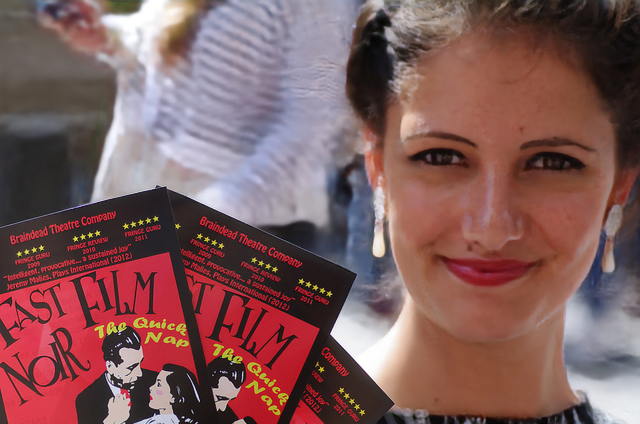


[EVAL IFAN][02/02] crim0148.jpg
Input


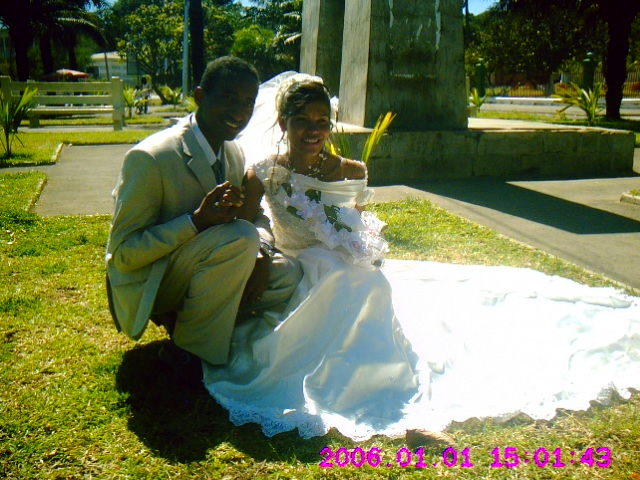


Output


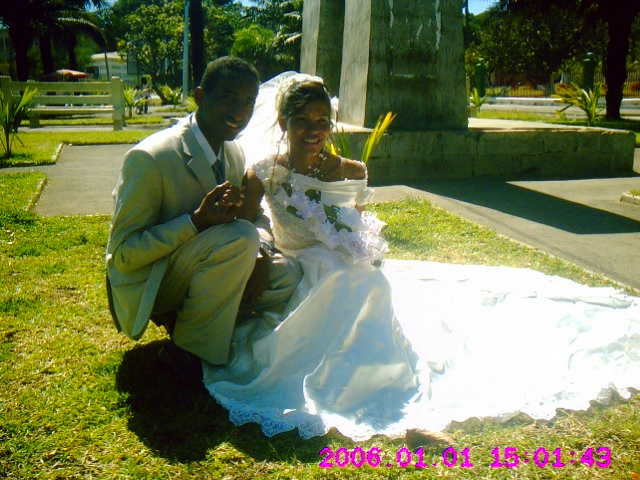

In [11]:
from data_loader.utils import load_file_list, refine_image, read_frame
## load inputs
print(toGreen('Reading Input(s)...'))
_, input_path_list, _ = load_file_list(input_offset, None, is_flatten=True)

print(toYellow('\n====== DEMO START ======'))
max_side = 1920
for i, input_path in enumerate(input_path_list):
    C_cpu = read_frame(input_path, config.norm_val, None)
    # resize image if max side exceeds 1920 (due to GPU mem)
    b, h, w, c = C_cpu.shape
    if max(h, w) > max_side:
        scale_ratio = max_side / max(h, w)
        C_cpu = np.expand_dims(cv2.resize(C_cpu[0], dsize=(int(w*scale_ratio), int(h*scale_ratio)), interpolation=cv2.INTER_AREA), 0)

    C = torch.FloatTensor(refine_image( C_cpu, config.refine_val).transpose(0, 3, 1, 2).copy()).cuda()

    ## running network
    init_time = time.time()
    with torch.no_grad():
        out = network(C, is_train=False)
    itr_time = time.time() - init_time
    print(toGreen('\n[EVAL {}][{:02}/{:02}] {}'.format(config.mode, i + 1, len(input_path_list), os.path.basename(input_path))))

    # display
    input_cpu = C_cpu[0]
    output = out['result']
    output_cpu = output.cpu().numpy()[0].transpose(1, 2, 0)

    print('Input')
    cv2_imshow(np.flip(input_cpu*255., 2).astype(np.uint8))

    print('\nOutput')
    cv2_imshow(np.flip(output_cpu*255., 2).astype(np.uint8))



Reading Input(s)...

====== DEMO START ======

[EVAL IFAN][01/02] input.jpg
Input


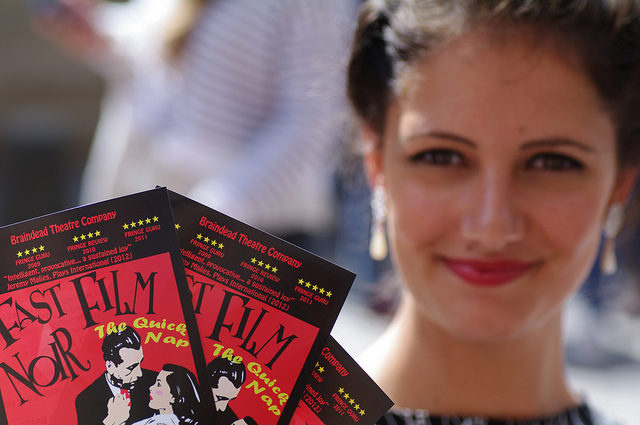


Output


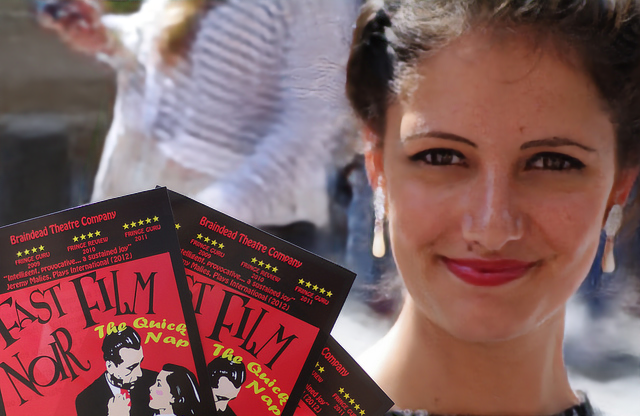


[EVAL IFAN][02/02] crim0148.jpg
Input


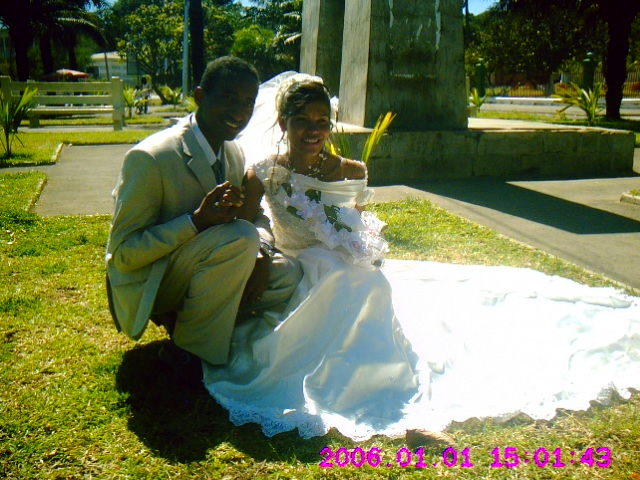


Output


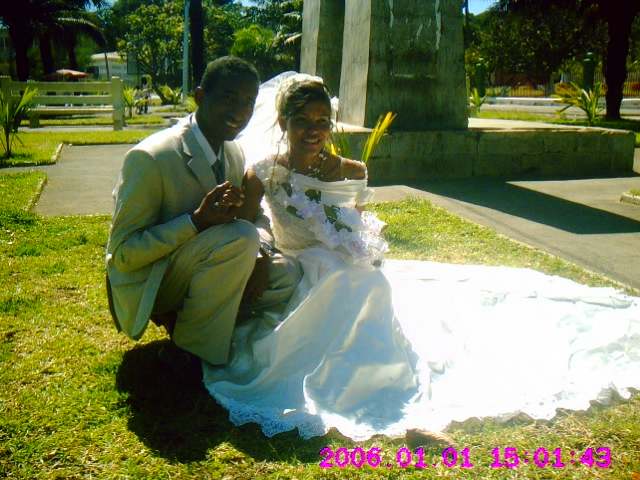

In [15]:
from data_loader.utils import load_file_list, refine_image, read_frame
## load inputs
print(toGreen('Reading Input(s)...'))
_, input_path_list, _ = load_file_list(input_offset, None, is_flatten=True)

print(toYellow('\n====== DEMO START ======'))
max_side = 1920
for i, input_path in enumerate(input_path_list):
    C_cpu = read_frame(input_path, config.norm_val, None)
    # resize image if max side exceeds 1920 (due to GPU mem)
    b, h, w, c = C_cpu.shape
    if max(h, w) > max_side:
        scale_ratio = max_side / max(h, w)
        C_cpu = np.expand_dims(cv2.resize(C_cpu[0], dsize=(int(w*scale_ratio), int(h*scale_ratio)), interpolation=cv2.INTER_AREA), 0)

    C = torch.FloatTensor(refine_image( C_cpu).transpose(0, 3, 1, 2).copy()).cuda()

    ## running network
    init_time = time.time()
    with torch.no_grad():
        out = network(C, is_train=False)
    itr_time = time.time() - init_time
    print(toGreen('\n[EVAL {}][{:02}/{:02}] {}'.format(config.mode, i + 1, len(input_path_list), os.path.basename(input_path))))

    # display
    input_cpu = C_cpu[0]
    output = out['result']
    output_cpu = output.cpu().numpy()[0].transpose(1, 2, 0)

    print('Input')
    cv2_imshow(np.flip(input_cpu*255., 2).astype(np.uint8))

    print('\nOutput')
    cv2_imshow(np.flip(output_cpu*255., 2).astype(np.uint8))



Reading Input(s)...

====== DEMO START ======

[EVAL IFAN][01/02] input.jpg
Input


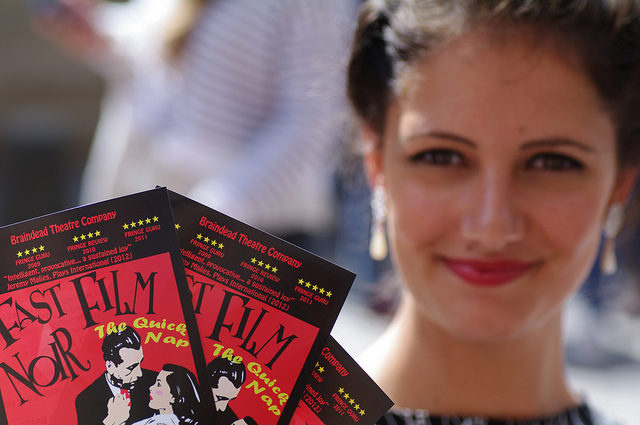


Output


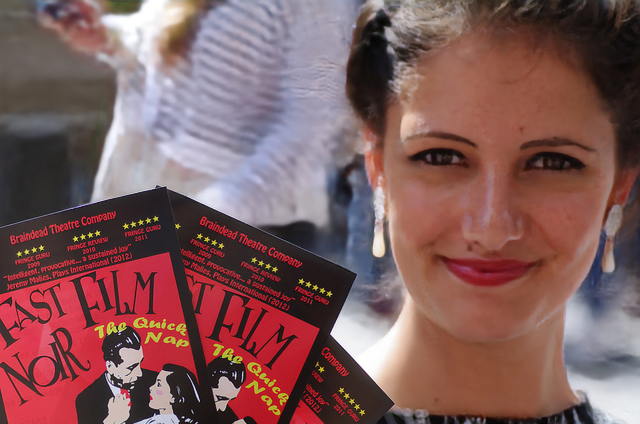


[EVAL IFAN][02/02] crim0148.jpg
Input


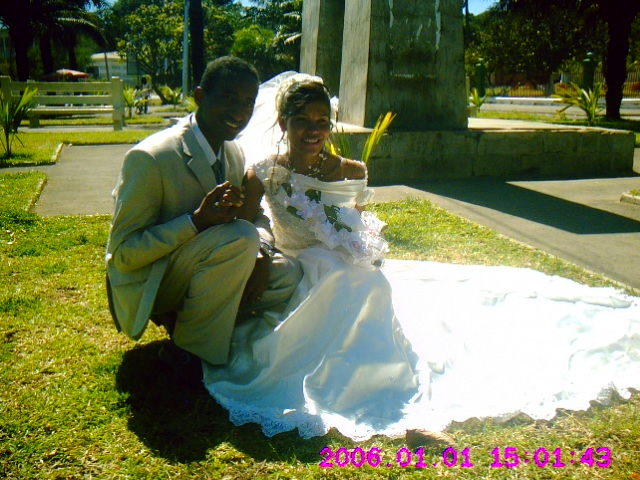


Output


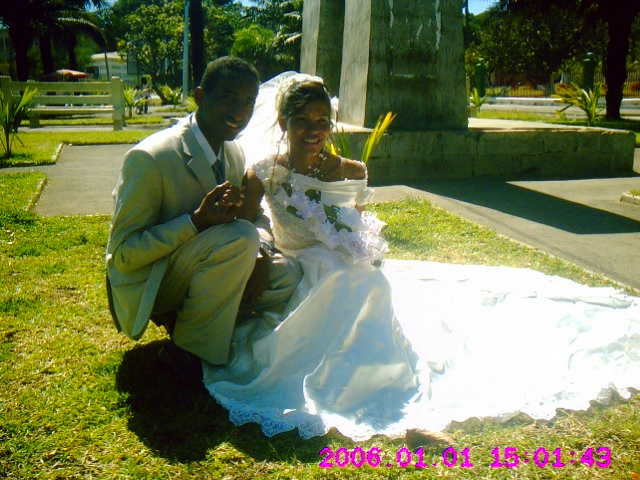

In [ ]:
from data_loader.utils import load_file_list, refine_image, read_frame
## load inputs
print(toGreen('Reading Input(s)...'))
_, input_path_list, _ = load_file_list(input_offset, None, is_flatten=True)

print(toYellow('\n====== DEMO START ======'))
max_side = 1920
for i, input_path in enumerate(input_path_list):
    C_cpu = read_frame(input_path, config.norm_val, None)
    # resize image if max side exceeds 1920 (due to GPU mem)
    b, h, w, c = C_cpu.shape
    if max(h, w) > max_side:
        scale_ratio = max_side / max(h, w)
        C_cpu = np.expand_dims(cv2.resize(C_cpu[0], dsize=(int(w*scale_ratio), int(h*scale_ratio)), interpolation=cv2.INTER_AREA), 0)

    C = torch.FloatTensor(refine_image( C_cpu, 32).transpose(0, 3, 1, 2).copy()).cuda()

    ## running network
    init_time = time.time()
    with torch.no_grad():
        out = network(C, is_train=False)
    itr_time = time.time() - init_time
    print(toGreen('\n[EVAL {}][{:02}/{:02}] {}'.format(config.mode, i + 1, len(input_path_list), os.path.basename(input_path))))

    # display
    input_cpu = C_cpu[0]
    output = out['result']
    output_cpu = output.cpu().numpy()[0].transpose(1, 2, 0)

    print('Input')
    cv2_imshow(np.flip(input_cpu*255., 2).astype(np.uint8))

    print('\nOutput')
    cv2_imshow(np.flip(output_cpu*255., 2).astype(np.uint8))

